Data Set Information:

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value.

Attribute Information:

0 Date (DD/MM/YYYY)
1 Time (HH.MM.SS)
2 True hourly averaged concentration CO in mg/m^3 (reference analyzer)
3 PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
4 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
5 True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
7 True hourly averaged NOx concentration in ppb (reference analyzer)
8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
12 Temperature in Â°C
13 Relative Humidity (%)
14 AH Absolute Humidity

Importing essential packages

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler         #import normalisation package
from sklearn.model_selection import train_test_split      #import train test split
from sklearn.linear_model import LinearRegression         #import linear regression package
from sklearn.metrics import mean_squared_error,mean_absolute_error   #import mean squared er

Data loading

In [37]:
def dataloader(path):
    col=['DATE','TIME','CO_GT','PT08_S1_CO','NMHC_GT','C6H6_GT','PT08_S2_NMHC',
     'NOX_GT','PT08_S3_NOX','NO2_GT','PT08_S4_NO2','PT08_S5_O3','T','RH','AH']
    #define number of columns from csv
    use=list(np.arange(len(col)))
    df=pd.read_csv(f"{path}.csv", sep=';')
    df_air=pd.read_csv(f"{path}1.csv",header=None,skiprows=1,names=col,na_filter=True,
                   na_values=-200,usecols=use)
    return df,df_air

In [38]:
col=['DATE','TIME','CO_GT','PT08_S1_CO','NMHC_GT','C6H6_GT','PT08_S2_NMHC',
     'NOX_GT','PT08_S3_NOX','NO2_GT','PT08_S4_NO2','PT08_S5_O3','T','RH','AH']

#define number of columns from csv
use=list(np.arange(len(col)))

#read the data from csv
df_air=pd.read_csv('AirQualityUCI1.csv',header=None,skiprows=1,names=col,na_filter=True,
                   na_values=-200,usecols=use)
#data1.head()
df_air.dropna(how='all',inplace=True)
#drop RH NAN rows
df_air.dropna(thresh=10,axis=0,inplace=True)
df_air['HOUR']=df_air['TIME'].apply(lambda x: int(x.split(':')[0]))
df_air['DATE']=pd.to_datetime(df_air.DATE, format='%m/%d/%Y')
df_air.set_index('DATE',inplace=True)
df_air['MONTH']=df_air.index.month     #Create month column (Run once)
df_air.reset_index(inplace=True)
df_air.drop('NMHC_GT',axis=1,inplace=True)
df_air['CO_GT']=df_air['CO_GT'].fillna(df_air.groupby(['MONTH','HOUR'])['CO_GT'].transform('mean'))
df_air['NOX_GT']=df_air['NOX_GT'].fillna(df_air.groupby(['MONTH','HOUR'])['NOX_GT'].transform('mean'))
df_air['NO2_GT']=df_air['NO2_GT'].fillna(df_air.groupby(['MONTH','HOUR'])['NO2_GT'].transform('mean'))
df_air['CO_GT']=df_air['CO_GT'].fillna(df_air.groupby(['HOUR'])['CO_GT'].transform('mean'))
df_air['NOX_GT']=df_air['NOX_GT'].fillna(df_air.groupby(['HOUR'])['NOX_GT'].transform('mean'))
df_air['NO2_GT']=df_air['NO2_GT'].fillna(df_air.groupby(['HOUR'])['NO2_GT'].transform('mean'))

In [39]:
path='AirQualityUCI'
data,df_air=dataloader(path)

How data looks 

In [21]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


In [6]:
#data.isnull().sum()
#data = data.dropna()
data.shape
data.describe()

,PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),Unnamed: 15,Unnamed: 16
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,0.0,0.0
mean,1048.990061,-159.090093,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,NaN,NaN
std,329.832710,139.789093,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,NaN,NaN
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,NaN,NaN
25%,921.000000,-200.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,NaN,NaN
50%,1053.000000,-200.000000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,NaN,NaN
75%,1221.000000,-200.000000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,NaN,NaN
max,2040.000000,1189.000000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,NaN,NaN


Preprocessing

In [40]:
def pre_processing(data,df_air):
    data = data.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1)
    data.dropna(how='all',inplace=True)
    #drop RH NAN rows
    data.dropna(thresh=10,axis=0,inplace=True)
    null_data = data[data.isnull().any(axis=1)]
    data = data.dropna()
    data = data.replace(-200, np.nan)
    data.isnull().sum()
    data['CO(GT)'] = data['CO(GT)'].str.replace(',', '.').astype(float)
    data['C6H6(GT)'] = data['C6H6(GT)'].str.replace(',','.').astype(float)
    data['T'] = data['T'].str.replace(',', '.').astype(float)
    data['RH'] = data['RH'].str.replace(',', '.').astype(float)
    data['AH'] = data['AH'].str.replace(',', '.').astype(float)

    df_air.dropna(how='all',inplace=True)
    #drop RH NAN rows
    df_air.dropna(thresh=10,axis=0,inplace=True)
    df_air['HOUR']=df_air['TIME'].apply(lambda x: int(x.split(':')[0]))
    df_air['DATE']=pd.to_datetime(df_air.DATE, format='%m/%d/%Y')
    df_air.set_index('DATE',inplace=True)
    df_air['MONTH']=df_air.index.month     #Create month column (Run once)
    df_air.reset_index(inplace=True)
    df_air.drop('NMHC_GT',axis=1,inplace=True)
    df_air['CO_GT']=df_air['CO_GT'].fillna(df_air.groupby(['MONTH','HOUR'])['CO_GT'].transform('mean'))
    df_air['NOX_GT']=df_air['NOX_GT'].fillna(df_air.groupby(['MONTH','HOUR'])['NOX_GT'].transform('mean'))
    df_air['NO2_GT']=df_air['NO2_GT'].fillna(df_air.groupby(['MONTH','HOUR'])['NO2_GT'].transform('mean'))
    df_air['CO_GT']=df_air['CO_GT'].fillna(df_air.groupby(['HOUR'])['CO_GT'].transform('mean'))
    df_air['NOX_GT']=df_air['NOX_GT'].fillna(df_air.groupby(['HOUR'])['NOX_GT'].transform('mean'))
    df_air['NO2_GT']=df_air['NO2_GT'].fillna(df_air.groupby(['HOUR'])['NO2_GT'].transform('mean'))
    return data,df_air

In [41]:
data,df_air=pre_processing(data,df_air)

In [34]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [43]:
df_air.describe()

,CO_GT,PT08_S1_CO,C6H6_GT,PT08_S2_NMHC,NOX_GT,PT08_S3_NOX,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH,HOUR,MONTH
count,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,2.087529,1099.833166,10.083105,939.153376,235.628247,835.493605,108.192116,1456.264598,1022.906128,18.317829,49.234201,1.025530,11.479591,6.327772
std,1.378000,217.080037,7.449820,266.831429,196.900245,256.817320,45.495667,346.206794,398.484288,8.832116,17.316892,0.403813,6.913320,3.407854
min,0.100000,647.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700,0.000000,1.000000
25%,1.043505,937.000000,4.400000,734.500000,100.307692,658.000000,73.554244,1227.000000,731.500000,11.800000,35.800000,0.736800,5.000000,3.000000
50%,1.800000,1063.000000,8.200000,909.000000,170.000000,806.000000,104.000000,1463.000000,963.000000,17.800000,49.600000,0.995400,11.000000,6.000000
75%,2.800000,1231.000000,14.000000,1116.000000,319.000000,969.500000,134.000000,1674.000000,1273.500000,24.400000,62.500000,1.313700,17.000000,9.000000
max,11.900000,2040.000000,63.700000,2214.000000,1479.000000,2683.000000,333.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000,23.000000,12.000000


In [16]:
data.dtypes

Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
Datetime          object
dtype: object

In [27]:
data.loc[:,'Datetime'] = data['Date'] + ' ' + data['Time']

In [28]:
from datetime import datetime
DateTime = []
for x in data['Datetime']:
    DateTime.append(datetime.strptime(x,'%d/%m/%Y %H.%M.%S'))


In [29]:
datetime = pd.Series(DateTime)
data.index = datetime

In [30]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime
2004-03-10 18:00:00,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,10/03/2004 18.00.00
2004-03-10 19:00:00,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,10/03/2004 19.00.00
2004-03-10 20:00:00,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,10/03/2004 20.00.00
2004-03-10 21:00:00,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,10/03/2004 21.00.00
2004-03-10 22:00:00,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,10/03/2004 22.00.00


In [17]:
data.corr()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
CO(GT),1.000000,0.117828,0.181408,-0.031378,0.077325,0.180565,-0.081036,0.161292,-0.060633,0.122234,-0.068939,-0.048227,-0.045892
PT08.S1(CO),0.117828,1.000000,0.790670,0.883795,0.892964,0.713654,-0.771938,0.641529,0.682881,0.899324,0.048627,0.114606,0.135324
NMHC(GT),0.181408,0.790670,1.000000,0.175638,0.877696,0.812685,-0.771135,0.731193,0.853267,0.766723,0.044555,-0.069237,-0.004347
C6H6(GT),-0.031378,0.883795,0.175638,1.000000,0.981950,0.011930,-0.735744,0.008709,0.765731,0.865689,0.971375,0.925062,0.984555
PT08.S2(NMHC),0.077325,0.892964,0.877696,0.981950,1.000000,0.704435,-0.796703,0.646245,0.777254,0.880578,0.241373,-0.090380,0.186933
NOx(GT),0.180565,0.713654,0.812685,0.011930,0.704435,1.000000,-0.655707,0.763111,0.233731,0.787046,-0.154516,-0.031934,-0.107324
PT08.S3(NOx),-0.081036,-0.771938,-0.771135,-0.735744,-0.796703,-0.655707,1.000000,-0.652083,-0.538468,-0.796569,-0.145112,-0.056740,-0.232017
NO2(GT),0.161292,0.641529,0.731193,0.008709,0.646245,0.763111,-0.652083,1.000000,0.157360,0.708128,-0.127494,-0.117413,-0.096899
PT08.S4(NO2),-0.060633,0.682881,0.853267,0.765731,0.777254,0.233731,-0.538468,0.157360,1.000000,0.591144,0.561270,-0.032188,0.629641
PT08.S5(O3),0.122234,0.899324,0.766723,0.865689,0.880578,0.787046,-0.796569,0.708128,0.591144,1.000000,-0.027172,0.124956,0.070751


Ploting corelation between variable

Text(0.5, 1.0, 'Heatmap of co-relation between variables')

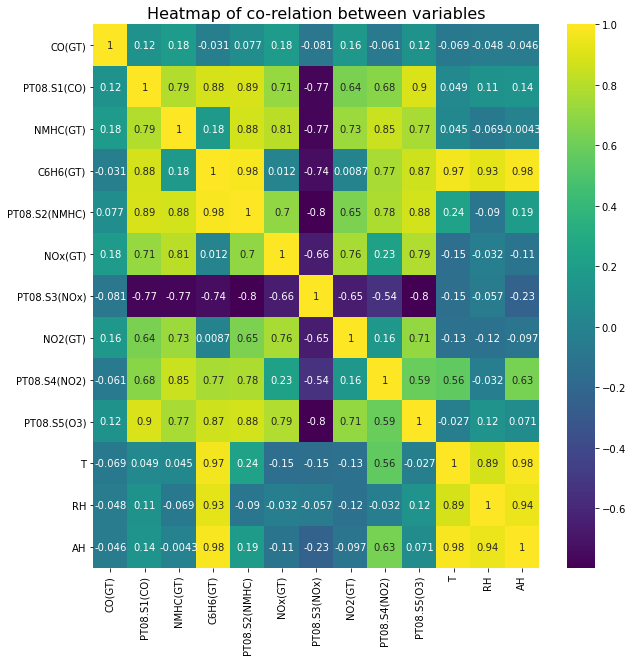

In [50]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),annot=True,cmap='viridis')
plt.title('Heatmap of co-relation between variables',fontsize=16)

In [45]:
#Subset data
S1 = data['PT08.S1(CO)'].fillna(data['PT08.S1(CO)'].mean())
S2 = data['PT08.S2(NMHC)'].fillna(data['PT08.S2(NMHC)'].mean())
S3 = data['PT08.S3(NOx)'].fillna(data['PT08.S3(NOx)'].mean())
S4 = data['PT08.S4(NO2)'].fillna(data['PT08.S4(NO2)'].mean())
S5 = data['PT08.S5(O3)'].fillna(data['PT08.S5(O3)'].mean())


In [46]:
df = pd.DataFrame({'S1':S1, 'S2':S1, 'S3':S3, 'S4':S4, 'S5':S5})

Text(0.5, 1.0, 'Heatmap of co-relation between variables')

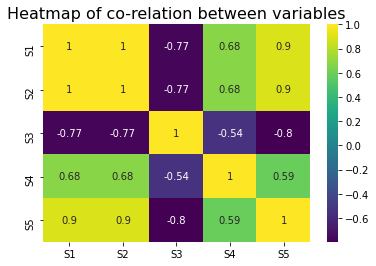

In [35]:
sns.heatmap(df.corr(),annot=True,cmap='viridis')
plt.title('Heatmap of co-relation between variables',fontsize=16)

Plotting timeseries

Text(0.5, 1.0, 'S5')

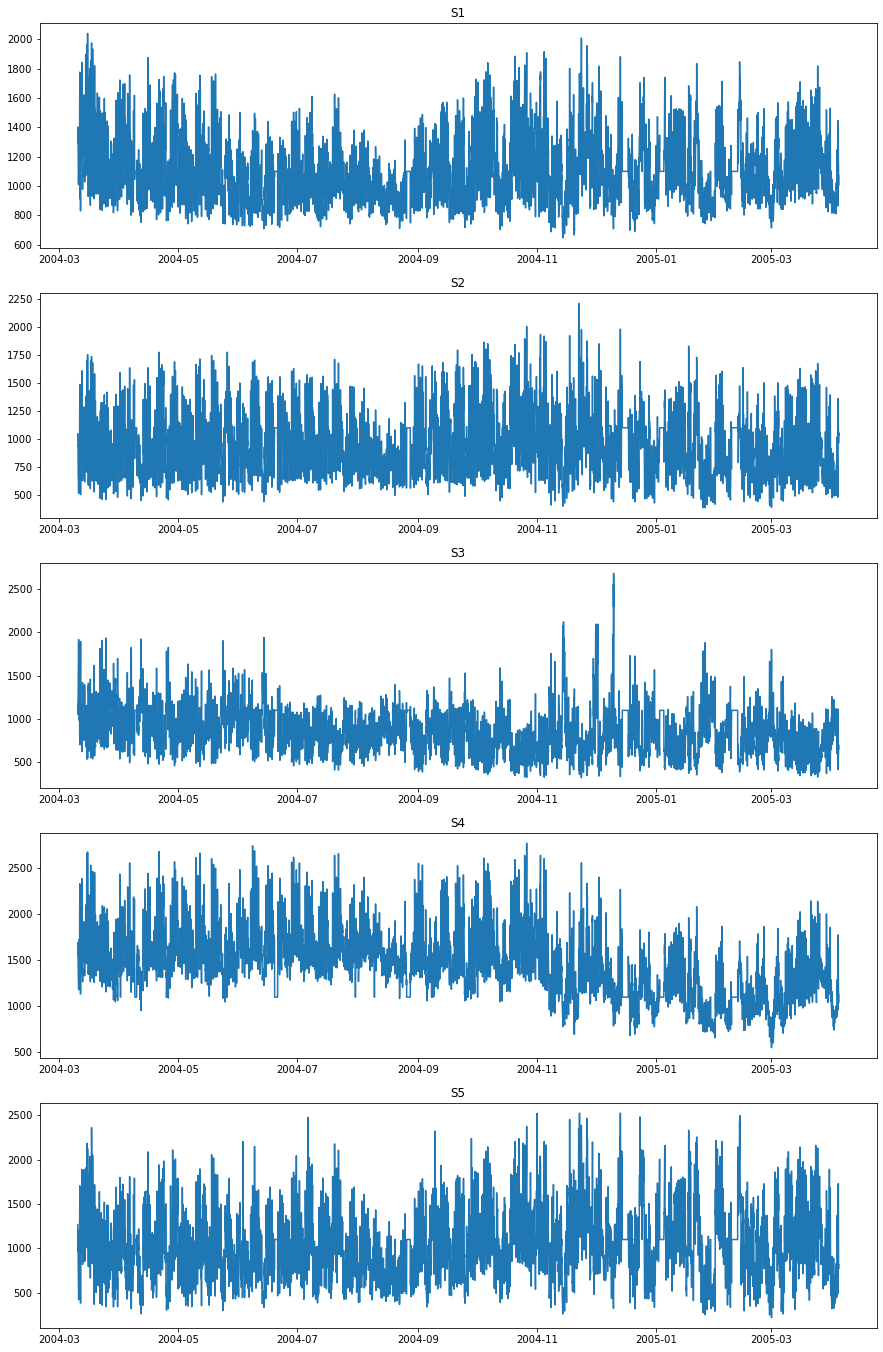

In [18]:
fig, axes = plt.subplots(5,1, figsize=(15,24))

axes[0].plot(S1)
axes[0].set_title ('S1')
axes[1].plot(S2)
axes[1].set_title ('S2')
axes[2].plot(S3)
axes[2].set_title ('S3')
axes[3].plot(S4)
axes[3].set_title ('S4')
axes[4].plot(S5)
axes[4].set_title ('S5')

Text(0.5, 1.0, 'S5')

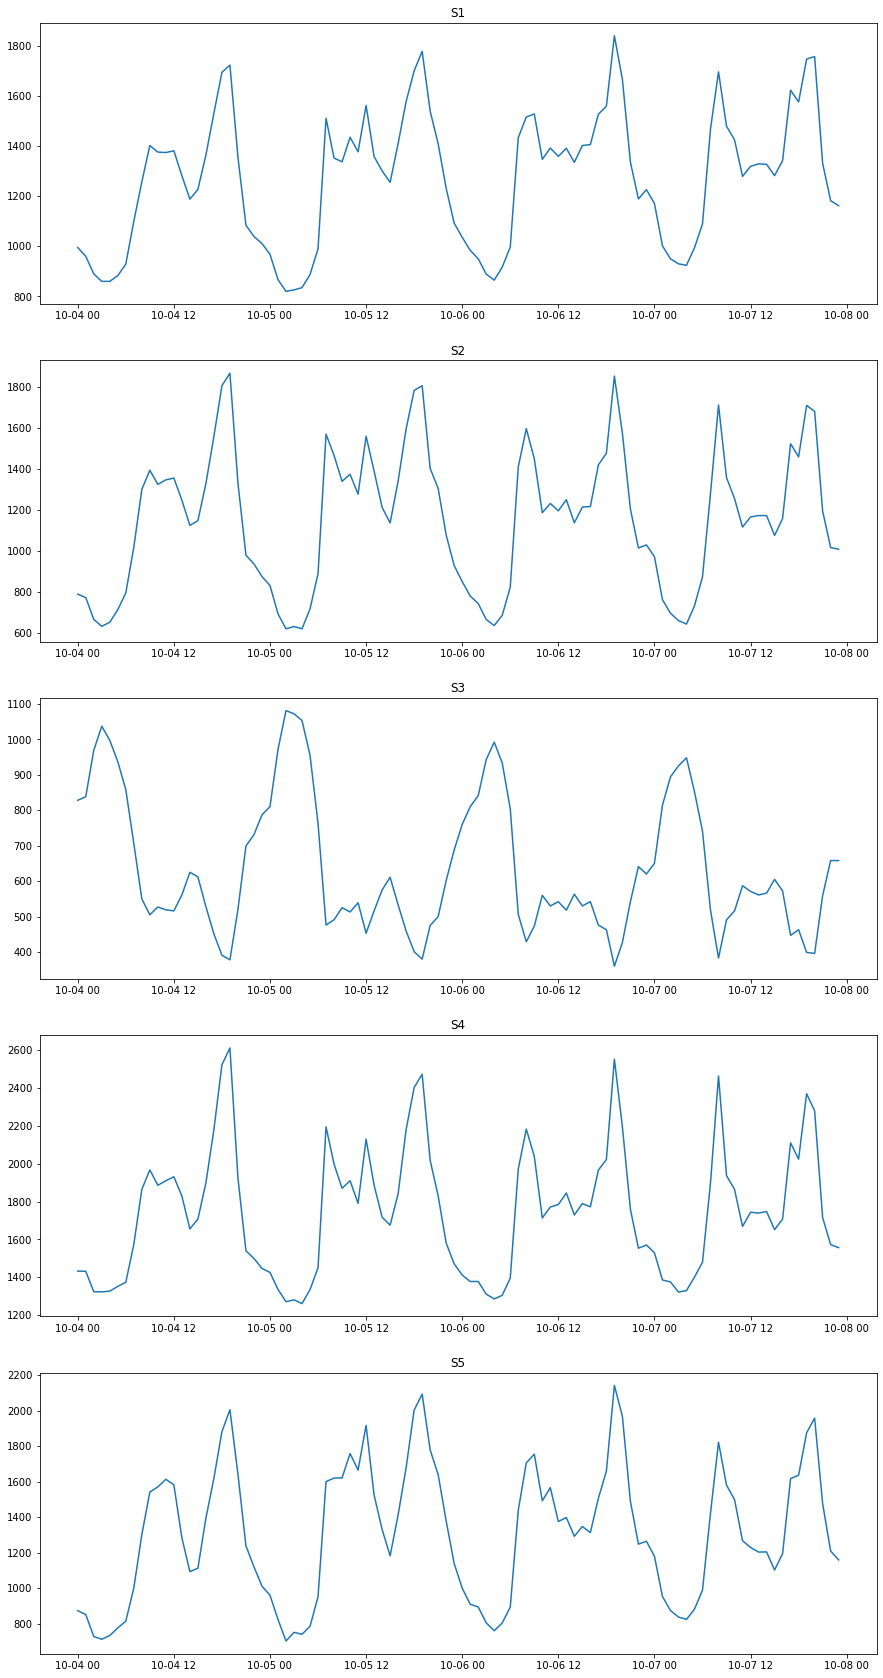

In [50]:
fig, axes = plt.subplots(5,1, figsize=(15,30))

axes[0].plot(S1['2004-10-04':'2004-10-07'])
axes[0].set_title ('S1')
axes[1].plot(S2['2004-10-04':'2004-10-07'])
axes[1].set_title ('S2')
axes[2].plot(S3['2004-10-04':'2004-10-07'])
axes[2].set_title ('S3')
axes[3].plot(S4['2004-10-04':'2004-10-07'])
axes[3].set_title ('S4')
axes[4].plot(S5['2004-10-04':'2004-10-07'])
axes[4].set_title ('S5')

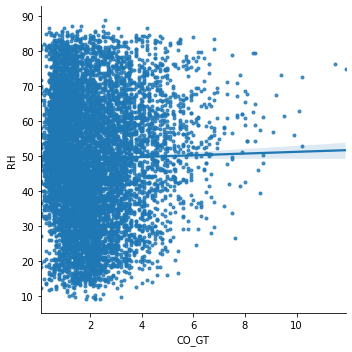

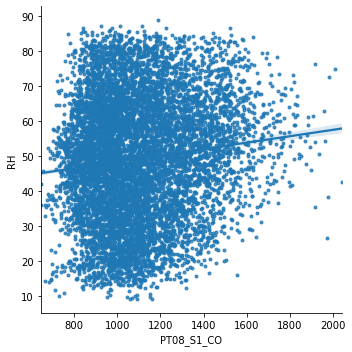

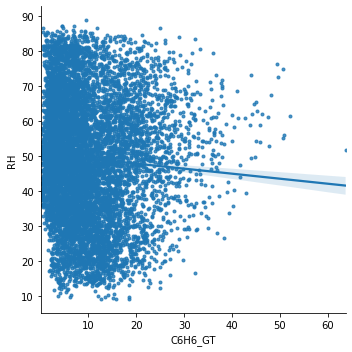

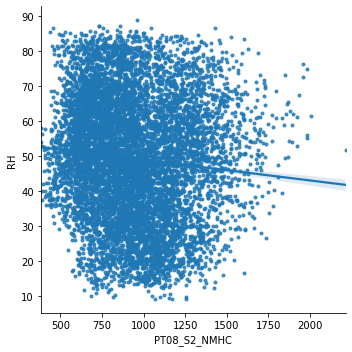

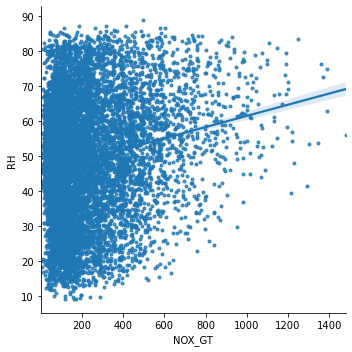

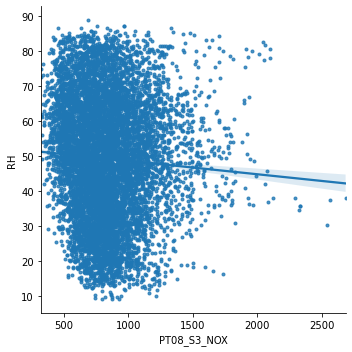

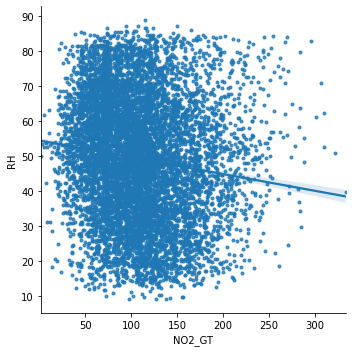

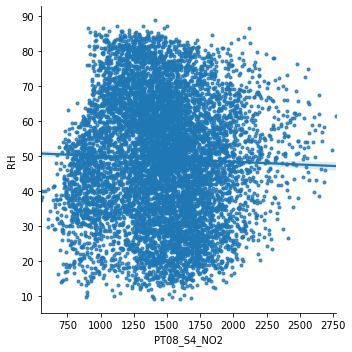

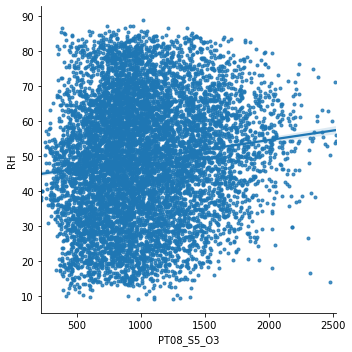

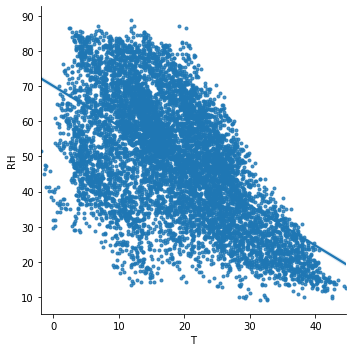

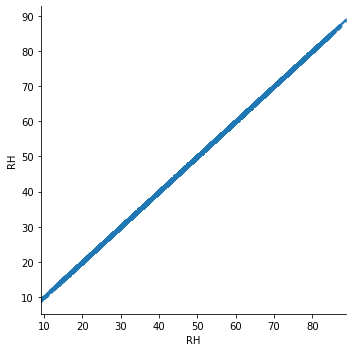

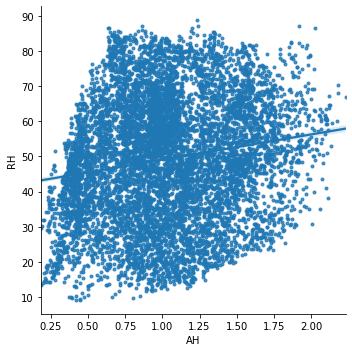

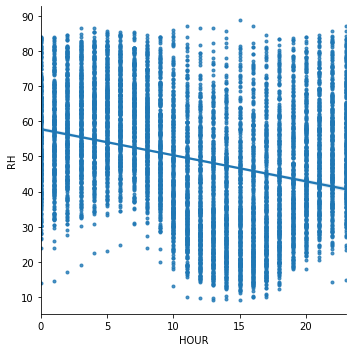

In [38]:
col_=df_air.columns.tolist()[2:-1]
for i in df_air.columns.tolist()[2:-1]:
    sns.lmplot(x=i,y='RH',data=df_air,markers='.')

In [39]:
X=df_air[col_].drop('RH',1)     #X-input features
y=df_air['RH'] 

In [41]:
ss=StandardScaler() 

In [42]:
X_std=ss.fit_transform(X) 

In [43]:
X_train, X_test, y_train, y_test=train_test_split(X_std,y,test_size=0.3, random_state=42)
print('Training data size:',X_train.shape)
print('Test data size:',X_test.shape)

Training data size: (6293, 12)
Test data size: (2698, 12)


In [45]:
lr=LinearRegression()
lr_model=lr.fit(X_train,y_train)
print('Intercept:',lr_model.intercept_)
print('--------------------------------')
print('Slope:')
list(zip(X.columns.tolist(),lr_model.coef_))  

Intercept: 49.20274655170931
--------------------------------
Slope:


[('CO_GT', -1.2809621431313098),
 ('PT08_S1_CO', 2.4564199233239625),
 ('C6H6_GT', -6.668263848171215),
 ('PT08_S2_NMHC', 1.3934832371322965),
 ('NOX_GT', 4.04431083553441),
 ('PT08_S3_NOX', -0.13343291758818898),
 ('NO2_GT', -1.7809285770544472),
 ('PT08_S4_NO2', 5.618436307187095),
 ('PT08_S5_O3', -1.0000933990483003),
 ('T', -20.060642146723858),
 ('AH', 13.102274317701232),
 ('HOUR', -0.6269556019120373)]

In [49]:
y_pred=lr_model.predict(X_test)                      #predict using the model
rmse=np.sqrt(mean_squared_error(y_test,y_pred))      #calculate rmse
print('Baseline RMSE of model:',rmse)

Baseline RMSE of model: 6.0764123862476795


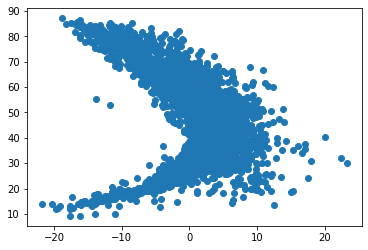

In [80]:
plt.scatter(y_pred-y_test,y_test)

In [48]:
# write function to measure RMSE
def train_test_RMSE(feature):
    X=df_air[feature]
    y=df_air['RH']
    X_std_one=ss.fit_transform(X)
    X_trainR,X_testR,y_trainR,y_testR=train_test_split(X_std_one,y,test_size=0.3,random_state=42)
    lr_model_one=lr.fit(X_trainR,y_trainR)
    y_predR=lr_model_one.predict(X_testR)
    return np.sqrt(mean_squared_error(y_testR,y_predR))

In [68]:
col_.remove('RH') 
print('List of features:',col_)    

List of features: ['CO_GT', 'PT08_S1_CO', 'C6H6_GT', 'PT08_S2_NMHC', 'NOX_GT', 'PT08_S3_NOX', 'NO2_GT', 'PT08_S4_NO2', 'PT08_S5_O3', 'T', 'AH', 'HOUR']


In [69]:
print('RMSE with Features as',col_[0:2],train_test_RMSE(col_[0:2]))
print('-------------------------')
print('RMSE with Features as',col_[0:6],train_test_RMSE(col_[0:6]))
print('-------------------------')
print('RMSE with Features as',col_[0:9],train_test_RMSE(col_[0:9]))
print('-------------------------')
print('RMSE with Features as',col_[1:5],train_test_RMSE(col_[2:9]))
print('-------------------------')
print('RMSE with Features as',col_[0:11],train_test_RMSE(col_[0:11]))
print('-------------------------')
print('RMSE with Features as',col_[1:12],train_test_RMSE(col_[1:12]))
print('-------------------------')
print('RMSE with Features as',col_[0:13],train_test_RMSE(col_[0:13]))

RMSE with Features as ['CO_GT', 'PT08_S1_CO'] 17.10722324985973
-------------------------
RMSE with Features as ['CO_GT', 'PT08_S1_CO', 'C6H6_GT', 'PT08_S2_NMHC', 'NOX_GT', 'PT08_S3_NOX'] 14.787924479855858
-------------------------
RMSE with Features as ['CO_GT', 'PT08_S1_CO', 'C6H6_GT', 'PT08_S2_NMHC', 'NOX_GT', 'PT08_S3_NOX', 'NO2_GT', 'PT08_S4_NO2', 'PT08_S5_O3'] 12.875243451046265
-------------------------
RMSE with Features as ['PT08_S1_CO', 'C6H6_GT', 'PT08_S2_NMHC', 'NOX_GT'] 13.364102349517681
-------------------------
RMSE with Features as ['CO_GT', 'PT08_S1_CO', 'C6H6_GT', 'PT08_S2_NMHC', 'NOX_GT', 'PT08_S3_NOX', 'NO2_GT', 'PT08_S4_NO2', 'PT08_S5_O3', 'T', 'AH'] 6.096537988670567
-------------------------
RMSE with Features as ['PT08_S1_CO', 'C6H6_GT', 'PT08_S2_NMHC', 'NOX_GT', 'PT08_S3_NOX', 'NO2_GT', 'PT08_S4_NO2', 'PT08_S5_O3', 'T', 'AH', 'HOUR'] 6.071109936275442
-------------------------
RMSE with Features as ['CO_GT', 'PT08_S1_CO', 'C6H6_GT', 'PT08_S2_NMHC', 'NOX_GT', 

Text(0, 0.5, 'S1_lagged')

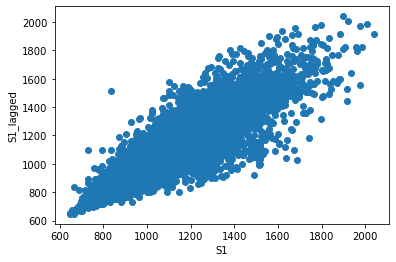

In [51]:
plt.scatter(S1, S1.shift())
plt.xlabel('S1')
plt.ylabel('S1_lagged')

In [52]:
S2_lagged = S2.shift()
pd.DataFrame({'real': S2, 'lagged': S2_lagged}).corr()

,real,lagged
real,1.000000,0.865785
lagged,0.865785,1.000000


Text(0, 0.5, 'S2_lagged')

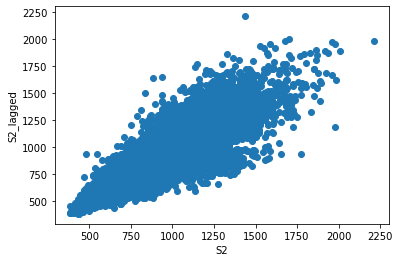

In [53]:
plt.scatter(S2, S2_lagged)
plt.xlabel('S2')
plt.ylabel('S2_lagged')

In [54]:
S3_lagged = S3.shift()
pd.DataFrame({'real': S3, 'lagged': S3_lagged}).corr()

,real,lagged
real,1.000000,0.905694
lagged,0.905694,1.000000


Text(0, 0.5, 'S3_lagged')

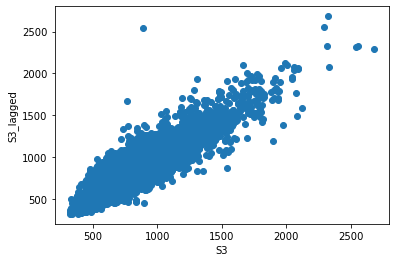

In [55]:
plt.scatter(S3, S3_lagged)
plt.xlabel('S3')
plt.ylabel('S3_lagged')

In [56]:
S4_lagged = S4.shift()
pd.DataFrame({'real': S4, 'lagged': S4_lagged}).corr()

,real,lagged
real,1.000000,0.910035
lagged,0.910035,1.000000


Text(0, 0.5, 'S4_lagged')

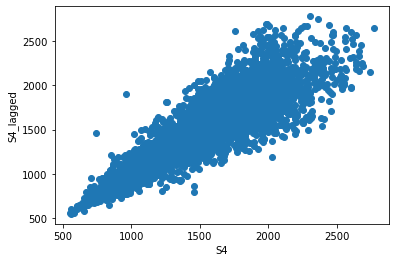

In [57]:
plt.scatter(S4, S4_lagged)
plt.xlabel('S4')
plt.ylabel('S4_lagged')

In [58]:
S5_lagged = S5.shift()
pd.DataFrame({'real': S5, 'lagged': S5_lagged}).corr()

,real,lagged
real,1.0000,0.8974
lagged,0.8974,1.0000


Text(0, 0.5, 'S5_lagged')

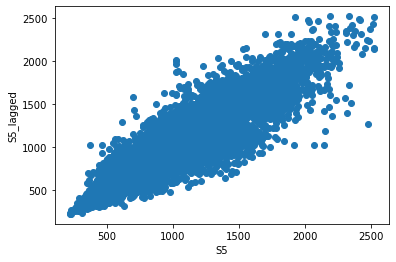

In [59]:
plt.scatter(S5, S5_lagged)
plt.xlabel('S5')
plt.ylabel('S5_lagged')


In [60]:
pd.DataFrame({'S1': S1, 'S2': S2, 'S3': S3, 'S4': S4, 'S5':S5}).corr()

,S1,S2,S3,S4,S5
S1,1.000000,0.892964,-0.771938,0.682881,0.899324
S2,0.892964,1.000000,-0.796703,0.777254,0.880578
S3,-0.771938,-0.796703,1.000000,-0.538468,-0.796569
S4,0.682881,0.777254,-0.538468,1.000000,0.591144
S5,0.899324,0.880578,-0.796569,0.591144,1.000000


Check Stationarity

In [61]:
from statsmodels.tsa.stattools import adfuller

In [62]:
def test_stationarity(timeseries):
    #Determing rolloing statistics
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()
    
    #Plot rolling statistics:
    orig = plt.plot (timeseries, color='blue', label='Original')
    mean = plt.plot (rolmean, color='red', label = 'Rolling Mean')
    std = plt.plot (rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('rolling Mean & Statndard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

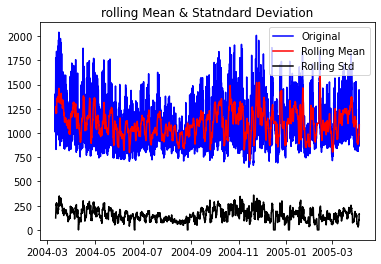

Results of Dickey-Fuller Test:
Test Statistic                -9.732395e+00
p-value                        8.932481e-17
#Lags Used                     3.800000e+01
Number of Observations Used    9.318000e+03
Critical Value (1%)           -3.431052e+00
Critical Value (5%)           -2.861850e+00
Critical Value (10%)          -2.566935e+00
dtype: float64


In [63]:
test_stationarity(S1)

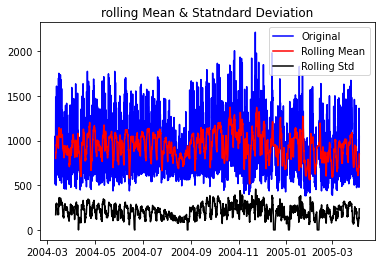

Results of Dickey-Fuller Test:
Test Statistic                -1.041322e+01
p-value                        1.781740e-18
#Lags Used                     3.700000e+01
Number of Observations Used    9.319000e+03
Critical Value (1%)           -3.431052e+00
Critical Value (5%)           -2.861850e+00
Critical Value (10%)          -2.566935e+00
dtype: float64


In [64]:
test_stationarity(S2)

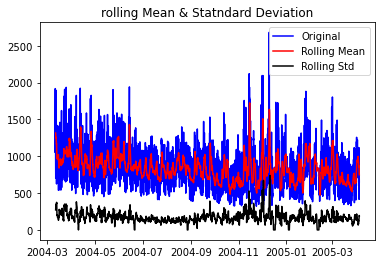

Results of Dickey-Fuller Test:
Test Statistic                -1.063839e+01
p-value                        5.003007e-19
#Lags Used                     3.600000e+01
Number of Observations Used    9.320000e+03
Critical Value (1%)           -3.431052e+00
Critical Value (5%)           -2.861850e+00
Critical Value (10%)          -2.566935e+00
dtype: float64


In [65]:
test_stationarity(S3)

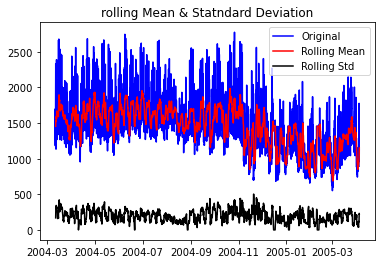

Results of Dickey-Fuller Test:
Test Statistic                -6.314130e+00
p-value                        3.181174e-08
#Lags Used                     3.700000e+01
Number of Observations Used    9.319000e+03
Critical Value (1%)           -3.431052e+00
Critical Value (5%)           -2.861850e+00
Critical Value (10%)          -2.566935e+00
dtype: float64


In [66]:
test_stationarity(S4)

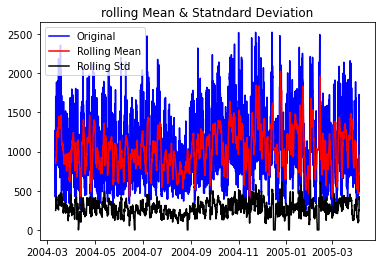

Results of Dickey-Fuller Test:
Test Statistic                -1.108278e+01
p-value                        4.269896e-20
#Lags Used                     3.600000e+01
Number of Observations Used    9.320000e+03
Critical Value (1%)           -3.431052e+00
Critical Value (5%)           -2.861850e+00
Critical Value (10%)          -2.566935e+00
dtype: float64


In [77]:
test_stationarity(S5)

In [149]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess

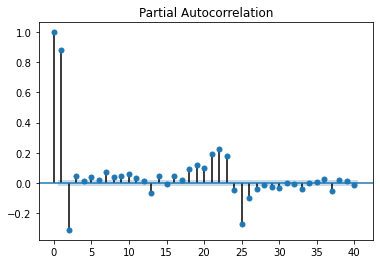

In [ ]:
plot_pacf(S1);

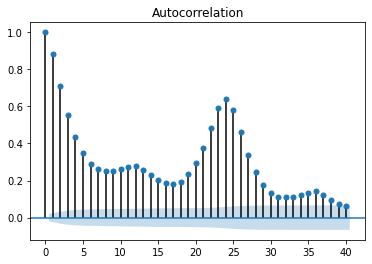

In [ ]:
plot_acf(S1);

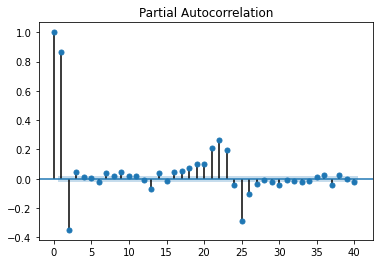

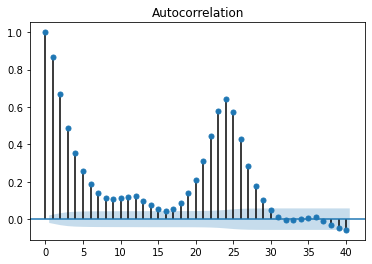

In [ ]:
plot_pacf(S2);
plot_acf(S2);

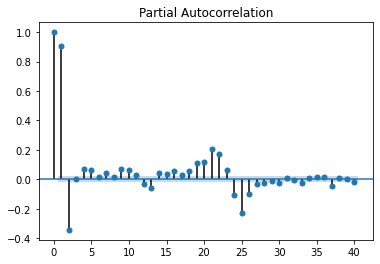

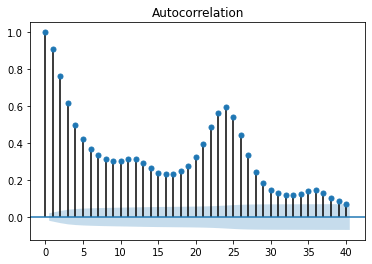

In [ ]:
plot_pacf(S3);
plot_acf(S3);

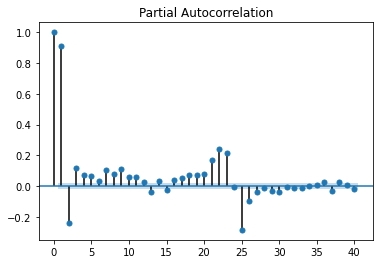

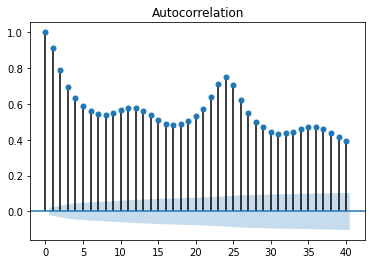

In [ ]:
plot_pacf(S4);
plot_acf(S4);

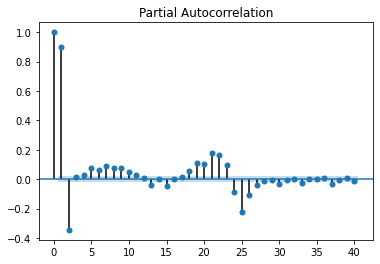

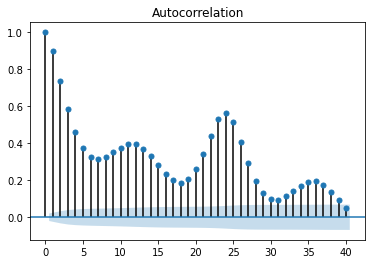

In [ ]:
plot_pacf(S5);
plot_acf(S5);

Arma model univariate

In [ ]:
import itertools
from statsmodels.tsa.arima_model import ARMA

In [ ]:
p=q=range(0,4)
pq=list(itertools.product(p,q))
print(pq)

params=[]
AICs=[]
print()


[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]



In [ ]:
df.values

array([[1360., 1360., 1056., 1692., 1268.],
       [1292., 1292., 1174., 1559.,  972.],
       [1402., 1402., 1140., 1555., 1074.],
       ...,
       [1142., 1142.,  603., 1241., 1092.],
       [1003., 1003.,  702., 1041.,  770.],
       [1071., 1071.,  654., 1129.,  816.]])

ARMA process for multivariate data

In [ ]:
for param in pq:
    try:
        mod=ARMA(df.values.reshape(-1).tolist(),order=param)
        result=mod.fit()
        print(result.summary())
        
        params.append(param)
        AICs.append(result.aic)
    except:
        continue

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                46785
Model:                     ARMA(0, 0)   Log Likelihood             -340600.674
Method:                           css   S.D. of innovations            351.141
Date:                Sat, 04 Dec 2021   AIC                         681205.347
Time:                        01:24:02   BIC                         681222.854
Sample:                             0   HQIC                        681210.848
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1102.7475      1.623    679.279      0.000    1099.566    1105.929
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observat

In [ ]:
#univariate case
for param in pq:
    try:
        mod=ARMA(S1,order=param)
        result=mod.fit()
        print()
        print(f"parameter values for p,q {param}")
        print(f"ARMA{param} - AIC{result.aic}")
        params.append(param)
        AICs.append(result.aic)
    except:
            continue

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'



parameter values for p,q (0, 0)
ARMA(0, 0) - AIC126869.92475471804

parameter values for p,q (0, 1)
ARMA(0, 1) - AIC118398.29670456113


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'



parameter values for p,q (0, 3)
ARMA(0, 3) - AIC113037.02908740556

parameter values for p,q (1, 0)
ARMA(1, 0) - AIC112745.21416118374


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'



parameter values for p,q (1, 1)
ARMA(1, 1) - AIC111816.83673315814


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'



parameter values for p,q (1, 2)
ARMA(1, 2) - AIC111774.48016999946


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'



parameter values for p,q (1, 3)
ARMA(1, 3) - AIC111769.1516101153


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'



parameter values for p,q (2, 0)
ARMA(2, 0) - AIC111785.8609245925


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'



parameter values for p,q (2, 1)
ARMA(2, 1) - AIC111771.32076806773


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'



parameter values for p,q (2, 2)
ARMA(2, 2) - AIC111772.85453220838


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'



parameter values for p,q (2, 3)
ARMA(2, 3) - AIC111624.16264861566


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'



parameter values for p,q (3, 0)
ARMA(3, 0) - AIC111770.06177537782


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'



parameter values for p,q (3, 1)
ARMA(3, 1) - AIC111571.00567462391


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'



parameter values for p,q (3, 2)
ARMA(3, 2) - AIC111571.62753637186


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'



parameter values for p,q (3, 3)
ARMA(3, 3) - AIC111457.08430696676


In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            PT08.S1(CO)   No. Observations:                 9357
Model:                     ARMA(3, 3)   Log Likelihood              -55720.542
Method:                       css-mle   S.D. of innovations             93.307
Date:                Thu, 02 Dec 2021   AIC                         111457.084
Time:                        18:18:01   BIC                         111514.235
Sample:                    03-10-2004   HQIC                        111476.494
                         - 04-04-2005                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1100.4823     12.329     89.256      0.000    1076.317    1124.648
ar.L1.PT08.S1(CO)     2.7185      0.010    278.215      0.000       2.699       2.738
ar.L2.PT08.S1(CO)    -2.5021      0.019   -134.427      0.000      -2.539      -2.466
ar.L3.PT08.S1(CO)     0.7815      0.009     86.346      0.000       0.764       0.799
ma.L1.PT08.S1(CO)    -1.5907      0.013   -124.240      0.000      -1.616      -1.566
ma.L2.PT08.S1(CO)     0.3405      0.021     15.931      0.000       0.299       0.382
ma.L3.PT08.S1(CO)     0.2765      0.011     25.225      0.000       0.255       0.298
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0381           -0.0000j            1.0381           -0.0000
AR.2            1.0818           -0.2497j            1.1103           -0.0361
AR.3            1.0818           +0.2497j            1.1103            0.0361
MA.1            1.0363           -0.1442j            1.0463           -0.0220
MA.2            1.0363           +0.1442j            1.0463            0.0220
MA.3           -3.3041           -0.0000j            3.3041           -0.5000
-----------------------------------------------------------------------------
"""

normailty check

(array([ 269., 1783., 2461., 2317., 1227.,  747.,  383.,  117.,   41.,
          12.]),
 array([ 647. ,  786.3,  925.6, 1064.9, 1204.2, 1343.5, 1482.8, 1622.1,
        1761.4, 1900.7, 2040. ]),
 <a list of 10 Patch objects>)

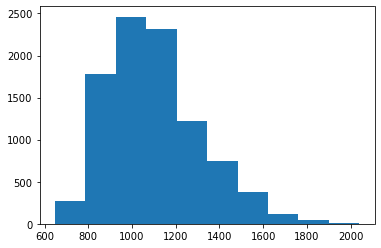

In [ ]:
plt.hist(S1)

In [ ]:
from statsmodels.graphics.gofplots import qqplot

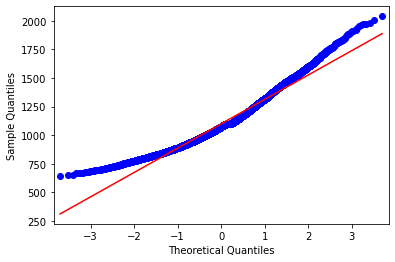

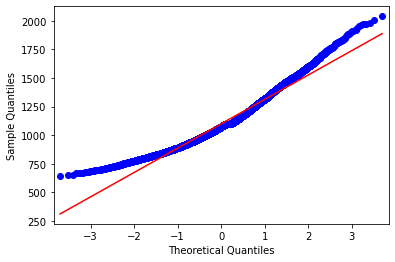

In [ ]:
qqplot(S1, line='s')

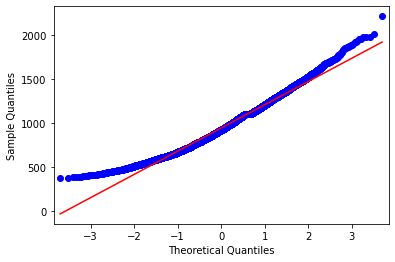

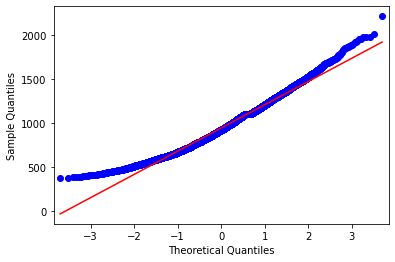

In [ ]:
qqplot(S2, line='s')

In [ ]:
from scipy.stats import shapiro

In [ ]:
stat, p = shapiro(S1)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.962, p=0.000
Sample does not look Gaussian (reject H0)


C:\Users\ASUS\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
from statsmodels.stats.weightstats import ztest

In [ ]:
null_mean =100
print('mean=%.2f stdv=%.2f' % (np.mean(S1), np.std(S1)))
ztest_Score, p_value= ztest(S1,value = null_mean, alternative='larger')

mean=1099.83 stdv=212.78


Randomness test based on turning points


In [ ]:
def turning_point_test(data,alpha=0.95):
    p=0
    for i in range(1,len(data)-1):
        if(data[i-1]-data[i]>0 and data[i]-data[i+1<0] or data[i-1]- data[i] < 0 and data[i] - data[i+1] > 0):
            p+=1
    
    if( alpha == 0.80):
        Z1 = 1.28
    elif ( alpha == 0.90):
        Z1 = 1.645
    elif( alpha == 0.95):
        Z1 = 1.96
    elif (alpha == 0.999):
        Z1 = 3.27

    E_p = (2 * ( len(data) - 2) / 3)
                 
    Var_p = ( (16 * len(data) ) - 29 )  / 90
        
    Z = (p - E_p) / np.sqrt(Var_p)
    
    if(Z1 > Z):
                 print("*****************************************************************************");
                 print("                      TEST SUMMARY          ");
                 print("******************************************************************************");
                 print(data);                
                 print("Number of data (n) = ", len(data));
                 print('Number of Turning Point(s) p =', p);
                 print('Expected Number of Turning points E(p) = ', E_p);
                 print("Variance of Turning Points Var(p) = ", Var_p);
                 print('Computed Z = ', Z);
                 print("Standerd Z = ", Z1);
                 print('Alpha = ', alpha);
                 print("******************************************************************************");
                 print ('Since computed Z < standard Z, THE SERIES IS RANDOM AT', alpha, 'Confidence level' );
                 print("******************************************************************************");
                    
                 
                 x = np.array([range(1,len(data), 1 )])
                    
                 import matplotlib.pyplot as plt
                 plt.plot(x, data)
                 plt.xlabel('Data Point')
                 plt.ylabel('Hydrological Data')
                 plt.title("Data Visualization / Time Series Plot")
                 plt.show()
    return Z,Z1

In [ ]:
Z,Z1=turning_point_test(S1)

In [ ]:
Z

4.936858721880144

In [ ]:
Z1

1.96

In [144]:
from pandas.plotting import autocorrelation_plot

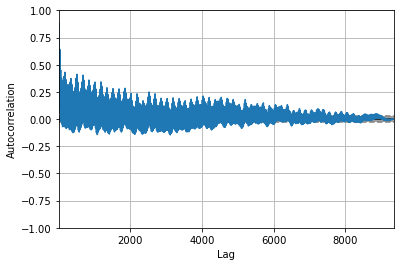

In [147]:
autocorrelation_plot(S1)

In [ ]:
import matplotlib.mlab as mlab

(array([3.65947920e+05, 5.45108166e+05, 1.97036101e+05, 1.31509594e+04,
        1.76436396e+04, 3.65629539e+04, 1.21813495e+04, 1.74737762e+03,
        1.20008027e+04, 9.30696946e+03, 8.48321349e+02, 4.02051137e+03,
        6.69120018e+03, 1.82015788e+03, 8.85306770e+02, 3.93291282e+03,
        2.41820869e+03, 1.70630694e+02, 1.94987708e+03, 2.46808982e+03,
        4.34949534e+02, 7.42723882e+02, 2.07052548e+03, 9.81654408e+02,
        2.10921710e+02, 1.29382328e+03, 1.19760280e+03, 1.64975025e+02,
        6.89224423e+02, 1.28945257e+03, 5.06532434e+02, 3.38135920e+02,
        1.04275776e+03, 7.27645575e+02, 1.40501166e+02, 6.48253223e+02,
        9.75314460e+02, 5.10982584e+02, 4.82724556e+02, 6.92181926e+02,
        5.31613543e+02, 1.17122269e+03, 2.57882033e+03, 2.64077517e+03,
        1.31067785e+03, 5.81448116e+02, 5.95650604e+02, 3.64607638e+02,
        2.44642844e+02, 5.01551178e+02, 4.19221106e+02, 1.06617011e+02,
        1.96944685e+02, 3.25822810e+02, 1.73468927e+02, 2.157963

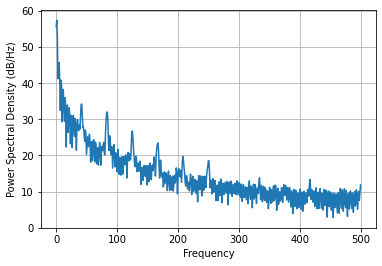

In [ ]:
plt.psd(S1, NFFT = 301,
       Fs = 1000,
       window = mlab.window_none,
       pad_to = 1024,
       scale_by_freq = True)

In [ ]:
from scipy import signal

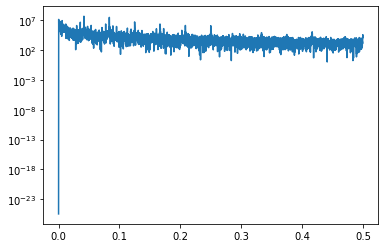

In [ ]:
fs = 10e3
f, Pxx_den=signal.periodogram(S1)
plt.semilogy(f, Pxx_den)

Problem:
Humans are very sensitive to humidity, as the skin relies on the air to get rid of moisture. The process of sweating is your body's attempt to keep cool and maintain its current temperature. If the air is at 100-percent relative humidity, sweat will not evaporate into the air. As a result, we feel much hotter than the actual temperature when the relative humidity is high. If the relative humidity is low, we can feel much cooler than the actual temperature because our sweat evaporates easily, cooling us off. For example, if the air temperature e is 75 degrees Fahrenheit (24 degrees Celsius) and the relative humidity is zero percent, the air temperature feels like 69 degrees Fahrenheit (21 C) to our bodies. If the air temperature is 75 degrees Fahrenheit (24 C) and the relative humidity is 100 percent, we feel like it's 80 degrees (27 C) out.

Objective:
So we will predict the Relative Humidity of a given point of time based on the all other attributes affecting the change in RH.

In [ ]:

import statsmodels.api as sm

In [132]:
result = sm.OLS(y, X).fit()

In [133]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     RH   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                          5.351e+04
Date:                Sat, 04 Dec 2021   Prob (F-statistic):                        0.00
Time:                        23:28:54   Log-Likelihood:                         -29058.
No. Observations:                8991   AIC:                                  5.814e+04
Df Residuals:                    8979   BIC:                                  5.823e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CO_GT           -1.0033      0.130     -7.711      0.000      -1.258      -0.748
PT08_S1_CO       0.0182      0.001     22.637      0.000       0.017       0.020
C6H6_GT         -1.7007      0.040    -42.675      0.000      -1.779      -1.623
PT08_S2_NMHC     0.0338      0.001     25.003      0.000       0.031       0.036
NOX_GT           0.0199      0.001     23.655      0.000       0.018       0.022
PT08_S3_NOX      0.0087      0.000     25.284      0.000       0.008       0.009
NO2_GT          -0.0278      0.003     -9.331      0.000      -0.034      -0.022
PT08_S4_NO2      0.0128      0.001     17.632      0.000       0.011       0.014
PT08_S5_O3      -0.0035      0.000     -7.116      0.000      -0.004      -0.003
T               -2.3119      0.013   -174.475      0.000      -2.338      -2.286
AH              35.5126      0.370     96.050      0.000      34.788      36.237
HOUR            -0.1245      0.012    -10.769      0.000      -0.147      -0.102
==============================================================================
Omnibus:                      369.962   Durbin-Watson:                   0.159
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              433.927
Skew:                           0.477   Prob(JB):                     5.94e-95
Kurtosis:                       3.497   Cond. No.                     1.43e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [134]:
yhat=result.resid

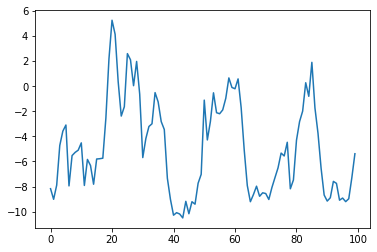

In [135]:
plt.plot(yhat[:100])


In [136]:
fitted=result.fittedvalues

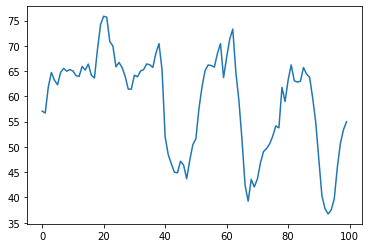

In [137]:
plt.plot(fitted[:100])

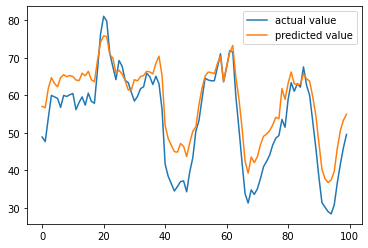

In [142]:
plt.plot(y[:100],label="actual value")
plt.plot(fitted[:100],label="predicted value")
plt.legend()

In [51]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [ ]:
model = pm.auto_arima(S1, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=24,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True, 
                      
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

In [ ]:
model.plot_diagnostics(figsize=(12.8,7.2))